In [4]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [5]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [6]:
ors = 12

In [8]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [9]:
# leer token
acceso = open(ruta_completa + '/_keys/api_amigocloud_gral.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [3]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

NameError: name 'path_puntos' is not defined

In [71]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,"MULTIPOINT (480692.621 8089936.437, 480734.955..."


In [72]:
multipoint_gdf = gdf_puntos_sem.copy()

In [73]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [74]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,POINT (480692.621 8089936.437)
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,POINT (480734.955 8090148.104)
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,POINT (480771.996 8089132.102)
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,POINT (480809.038 8088587.059)
18,75,AGUILERA TARADELLES NELSON MARIANO,11,NaN,NaN,POINT (481444.039 8089772.395)


<Axes: >

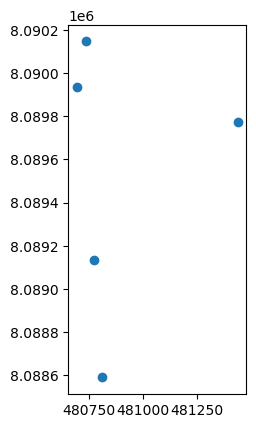

In [75]:
puntos_indi.plot()

In [76]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [77]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [78]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
13425,256.0,LOS ANDES--AGUILERA,577.0,AGUILERA MARIA INGRID WENDE DE,LA20,7.890023,2.0,50,"POLYGON ((481237.012 8089847.643, 481636.666 8..."
13426,256.0,LOS ANDES--AGUILERA,577.0,AGUILERA MARIA INGRID WENDE DE,LA16,24.621769,2.0,50,"POLYGON ((480558.376 8088818.995, 481054.399 8..."
13427,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,1.0,50,"POLYGON ((480301.359 8089838.440, 480241.822 8..."
13429,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA23,15.996730,1.0,50,"POLYGON ((481067.239 8090028.913, 480287.808 8..."
13433,256.0,LOS ANDES--AGUILERA,577.0,AGUILERA MARIA INGRID WENDE DE,LA1,30.346484,2.0,50,"POLYGON ((480565.400 8088825.256, 480561.546 8..."


In [79]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [80]:
poligonos_intersect_cat.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
13425,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA20,7.890023,2.0,50,"POLYGON ((481237.012 8089847.643, 481636.666 8..."
13426,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA16,24.621769,2.0,50,"POLYGON ((480558.376 8088818.995, 481054.399 8..."
13427,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,1.0,50,"POLYGON ((480301.359 8089838.440, 480241.822 8..."


In [81]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [82]:
plan = poligonos_intersect_cat.copy()

In [83]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
13425,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA20,7.890023,2.0,50,"POLYGON ((481237.012 8089847.643, 481636.666 8...",11
13426,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA16,24.621769,2.0,50,"POLYGON ((480558.376 8088818.995, 481054.399 8...",11
13427,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,1.0,50,"POLYGON ((480301.359 8089838.440, 480241.822 8...",11


<Axes: >

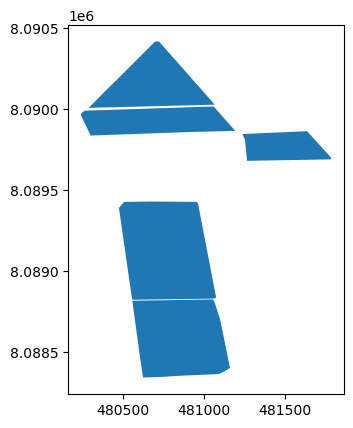

In [84]:
plan.plot()

In [85]:
plan['area'].sum()

92.06006487329

In [86]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [87]:
plan['area'].sum()

92.06006487329279

In [88]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [89]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [90]:
last_id

139

In [91]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [92]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
13425,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA20,7.890023,2.0,50,"POLYGON ((481237.012 8089847.643, 481636.666 8...",11,140
13426,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA16,24.621769,2.0,50,"POLYGON ((480558.376 8088818.995, 481054.399 8...",11,141
13427,256.0,LOS ANDES--AGUILERA,75.0,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,1.0,50,"POLYGON ((480301.359 8089838.440, 480241.822 8...",11,142


In [93]:
len(plan)

5

In [94]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [95]:
gdf_pla_gral['area'].sum()

1403.037955828808

In [96]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [97]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
133,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA20,7.890023,11,2,140,50,NaN,"POLYGON ((481237.012 8089847.643, 481636.666 8..."
134,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA16,24.621769,11,2,141,50,NaN,"POLYGON ((480558.376 8088818.995, 481054.399 8..."
135,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,11,1,142,50,NaN,"POLYGON ((480301.359 8089838.440, 480241.822 8..."
136,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA23,15.996730,11,1,143,50,NaN,"POLYGON ((481067.239 8090028.913, 480287.808 8..."


In [98]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [100]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [101]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [102]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [103]:
len(gdf_pla_gral)

5

In [104]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [105]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [106]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [107]:
excel_data = pd.read_excel(path_xlsx_parte)

In [108]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
13425,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA20,7.890023,2,50,"MULTIPOLYGON (((-63.17653 -17.27650, -63.17277...",11,140
13426,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA16,24.621769,2,50,"MULTIPOLYGON (((-63.18293 -17.28580, -63.17826...",11,141
13427,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA24,13.205059,1,50,"MULTIPOLYGON (((-63.18534 -17.27658, -63.18590...",11,142
13429,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA23,15.996730,1,50,"MULTIPOLYGON (((-63.17813 -17.27486, -63.18546...",11,143
13433,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,LA1,30.346484,2,50,"MULTIPOLYGON (((-63.18286 -17.28574, -63.18290...",11,144


In [109]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [110]:
new_df.head(3)

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA20,7.890023,2,140,11
1,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA16,24.621769,2,141,11
2,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA24,13.205059,1,142,11


In [111]:
# extrae los valores de Nº DE LABOR, convierte a conjunto y luego a lista
lista_cite = list(set(excel_data['Nº DE LABOR']))

In [112]:
# extrae los valores numericos de cada Nº DE LABOR
lista_num = [int(i.split('-')[-1]) for i in lista_cite]
lista_num

[9, 12, 18, 4, 2, 10, 6, 24, 23, 21, 19, 14, 1, 22, 17, 11, 13, 8, 5, 20, 15]

In [113]:
next_num_labor = max(lista_num) + 1
next_num_labor

25

In [114]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-' + str(next_num_labor)

In [115]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA20,7.890023,2,140,11,0,PUL. CON DRONE,PA-2025-25
1,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA16,24.621769,2,141,11,0,PUL. CON DRONE,PA-2025-25
2,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA24,13.205059,1,142,11,0,PUL. CON DRONE,PA-2025-25
3,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA23,15.996730,1,143,11,0,PUL. CON DRONE,PA-2025-25
4,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,LA1,30.346484,2,144,11,0,PUL. CON DRONE,PA-2025-25


In [116]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [117]:
final_data.to_excel(path_xlsx_parte, index=False)